# [CV-06] CAM을 만들고 평가해 보자

## 데이터 및 라이브러리 준비

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

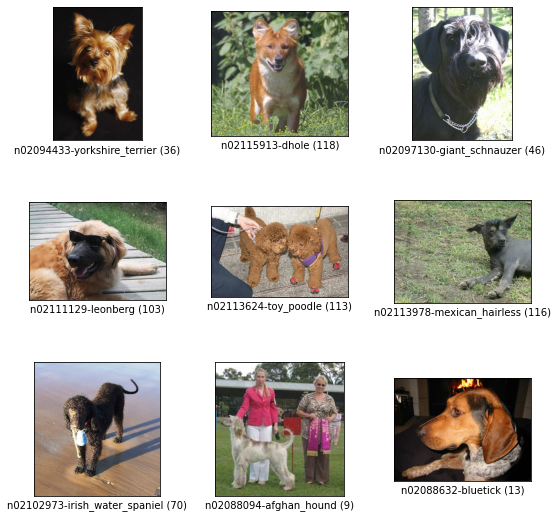

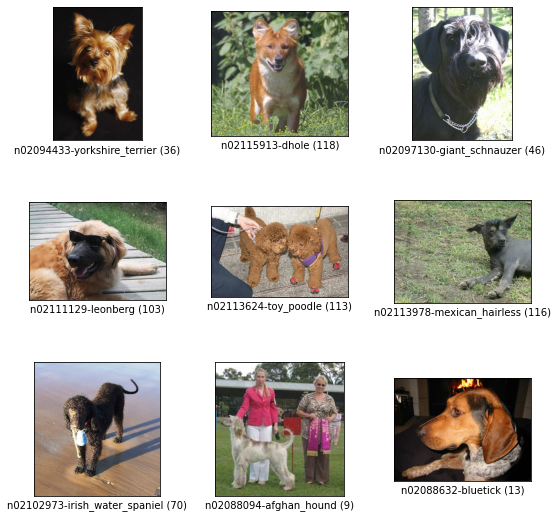

In [3]:
tfds.show_examples(ds_train, ds_info)

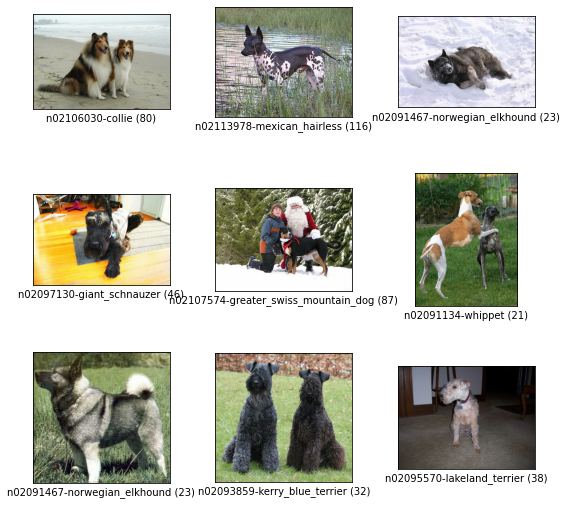

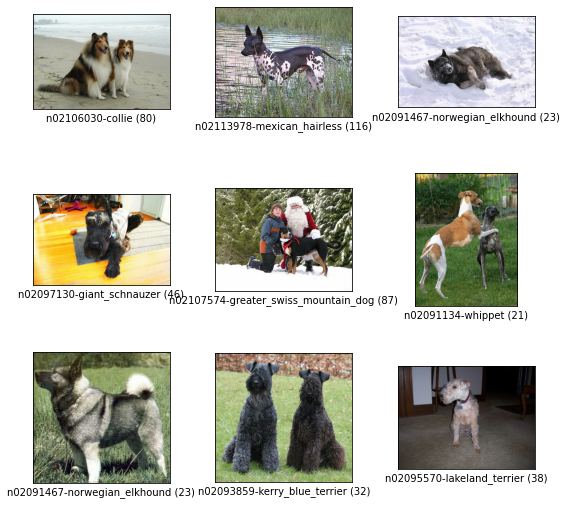

In [4]:
tfds.show_examples(ds_test, ds_info)

## CAM 모델링

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [6]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [7]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## 모델 학습

In [8]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
# 데이터셋에 전처리와 배치처리를 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [10]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 103s 126ms/step - loss: 0.6255 - accuracy: 0.8337 - val_loss: 1.0893 - val_accuracy: 0.6812
Epoch 2/15
750/750 [==============================] - 95s 127ms/step - loss: 0.2276 - accuracy: 0.9538 - val_loss: 0.9788 - val_accuracy: 0.7192
Epoch 3/15
750/750 [==============================] - 94s 126ms/step - loss: 0.0646 - accuracy: 0.9948 - val_loss: 0.9553 - val_accuracy: 0.7262
Epoch 4/15
750/750 [==============================] - 95s 126ms/step - loss: 0.0236 - accuracy: 0.9987 - val_loss: 0.9210 - val_accuracy: 0.7424
Epoch 5/15
750/750 [==============================] - 95s 127ms/step - loss: 0.0123 - accuracy: 0.9999 - val_loss: 0.9350 - val_accuracy: 0.7441
Epoch 6/15
750/750 [==============================] - 94s 126ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.9306 - val_accuracy: 0.7452
Epoch 7/15
750/750 [==============================] - 94s 126ms/step - loss: 0.0088 - accuracy: 0.9998 - val_loss: 1.0440 - val_a

In [13]:
## 가중치 저장

# import os

# cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
# cam_model.save(cam_model_path)
# print("저장 완료!")

In [14]:
# # 앞 코드 한번에 정리

# import tensorflow as tf
# from tensorflow import keras
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow_datasets as tfds
# import copy
# import cv2
# from PIL import Image

# (ds_train, ds_test), ds_info = tfds.load(
#     'stanford_dogs',
#     split=['train', 'test'],
#     shuffle_files=True,
#     with_info=True,
# )

# def normalize_and_resize_img(input):
#     # Normalizes images: `uint8` -> `float32`
#     image = tf.image.resize(input['image'], [224, 224])
#     input['image'] = tf.cast(image, tf.float32) / 255.
#     return input['image'], input['label']

# def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
#     ds = ds.map(
#         normalize_and_resize_img, 
#         num_parallel_calls=2
#     )
#     ds = ds.batch(batch_size)
#     if not is_test:
#         ds = ds.repeat()
#         ds = ds.shuffle(200)
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
#     return ds

In [15]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

108


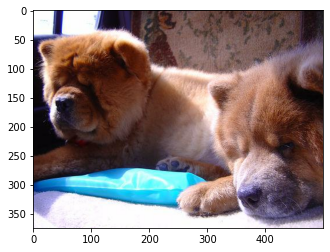

In [16]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [17]:
import os
cam_model_path = '/content/drive/MyDrive/Colab Notebooks/data/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [18]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해 모델의 input과 output을 새롭게 정의
    # model.layers[-3].output에서는 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있음
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옴
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize
    return cam_image

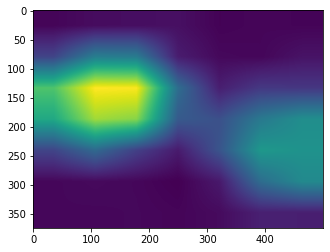

In [19]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [20]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

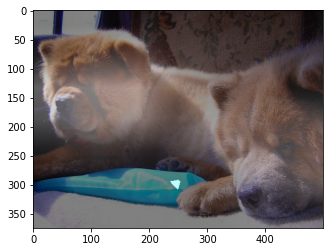

In [21]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## Grad-CAM

80


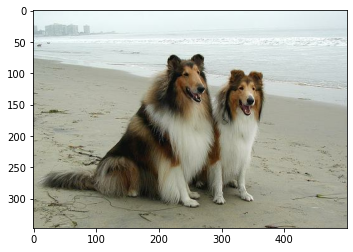

In [22]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [23]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻음
        output = conv_output[0] # 원하는 layer의 output을 얻음
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻음

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구함
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻음
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

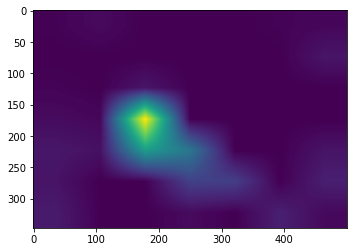

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

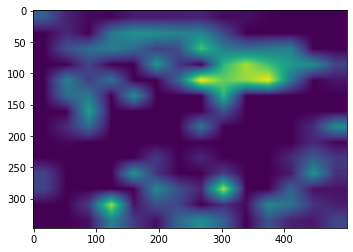

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

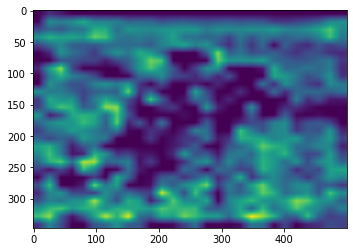

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## Detection with CAM

### Bounding Box

67


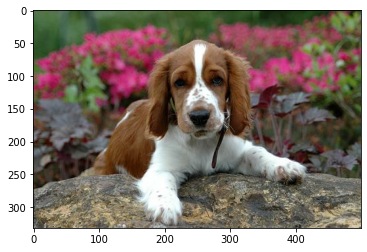

In [27]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

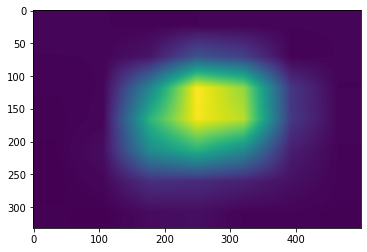

In [28]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [29]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [30]:
rect = get_bbox(cam_image)
rect

array([[111, 294],
       [111,  33],
       [443,  33],
       [443, 294]])

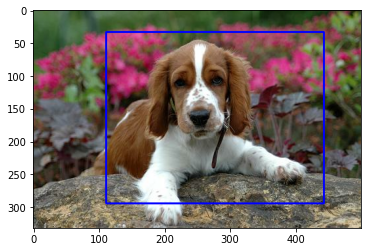

In [31]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

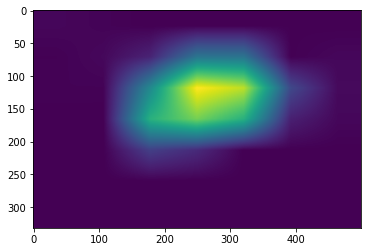

In [32]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [33]:
image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[140, 273],
       [ 79,  72],
       [409, -27],
       [471, 172]])

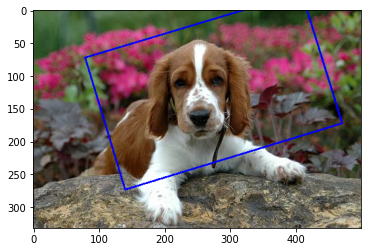

In [34]:
image = cv2.drawContours(image, [grad_rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Intersection Over Union

In [35]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어짐
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [36]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09939759036144578, 0.222, 0.8855421686746988, 0.886]

In [37]:
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[-0.08132530120481928, 0.158, 0.822289156626506, 0.942]

In [38]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [39]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [40]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6983858334151163

In [41]:
get_iou(grad_pred_bbox, item['objects']['bbox'][0])

0.553156846572964

## 프로젝트를 마치며

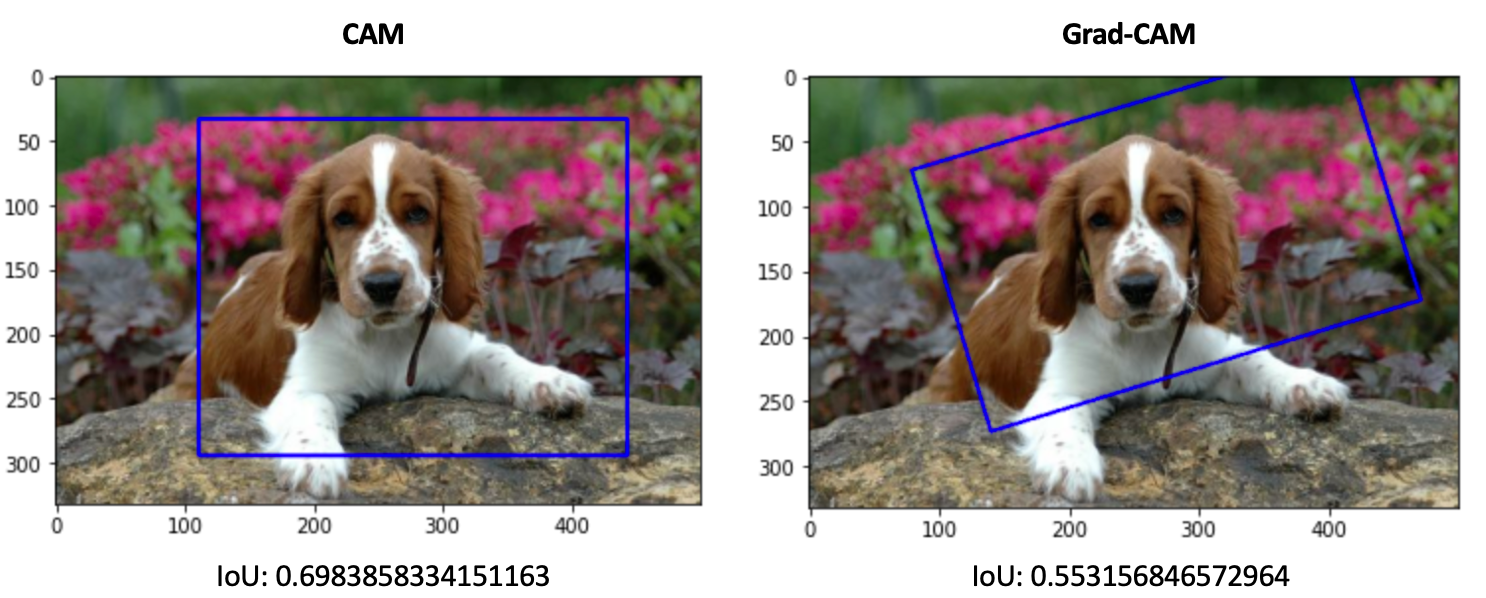

CAM과 Grad-CAM 방식을 통해 얻은 Class activation map을 각각 시각화하였다.
바운딩 박스를 확인해보면 CAM의 방식이 object의 위치를 더 잘 반영한 듯 보였다. 반면, Grad-CAM의 바운딩 박스는 object를 잘 찾아냈지만 기울어진 모습을 보이고 있다. 이 때문에 object의 많은 부분이 박스를 벗어났다. 두 방식의 IoU를 확인해보면 CAM의 IoU가 더 높게 계산된 것을 확인할 수 있었고 둘의 IoU은 생각보다 많이 차이가 났다. CAM 방식이 넓긴 하지만 대부분의 object를 찾아내고 포함시켰기 때문에 성능이 더 좋게 나타난 것 같다. 하지만 성능을 높이기 위해 바운딩 박스를 넓게 하는 것이 옳은 방법이라고 할 수 있을지는 모르겠다. object가 많은 이미지를 다룬다면 오히려 면적을 좁게 하는 것이 더 유용하게 사용되지 않을까?